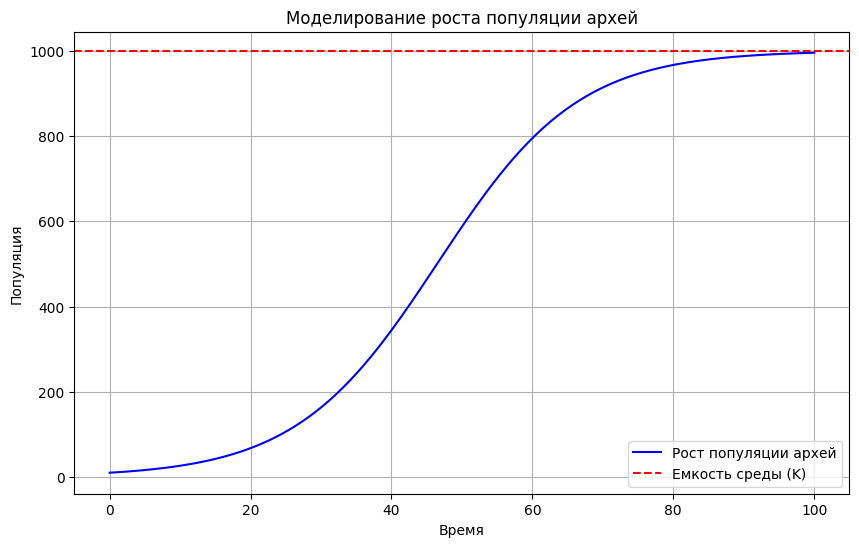

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры модели
r = 0.1  # коэффициент роста
K = 1000  # емкость среды
P0 = 10  # начальная популяция
t_max = 100  # максимальное время
dt = 0.25  # шаг по времени
num_steps = int(t_max / dt)  # количество шагов

# Инициализация массивов
t = np.linspace(0, t_max, num_steps)
P = np.zeros(num_steps)
P[0] = P0  # начальная популяция

# Метод Эйлера для решения дифференциального уравнения
for i in range(1, num_steps):
    dP = r * P[i-1] * (1 - P[i-1] / K)  # изменение популяции
    P[i] = P[i-1] + dP * dt  # обновление популяции

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(t, P, label='Рост популяции архей', color='blue')
plt.title('Моделирование роста популяции архей')
plt.xlabel('Время')
plt.ylabel('Популяция')
plt.axhline(y=K, color='r', linestyle='--', label='Емкость среды (K)')
plt.legend()
plt.grid()
plt.show()

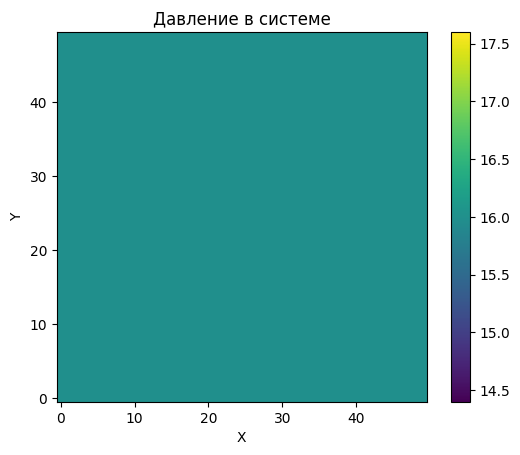

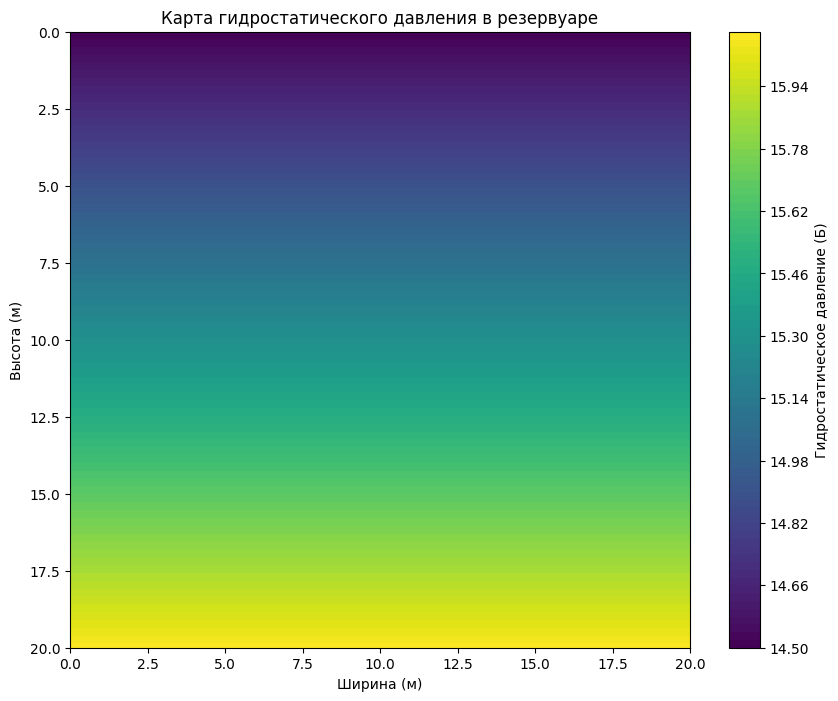

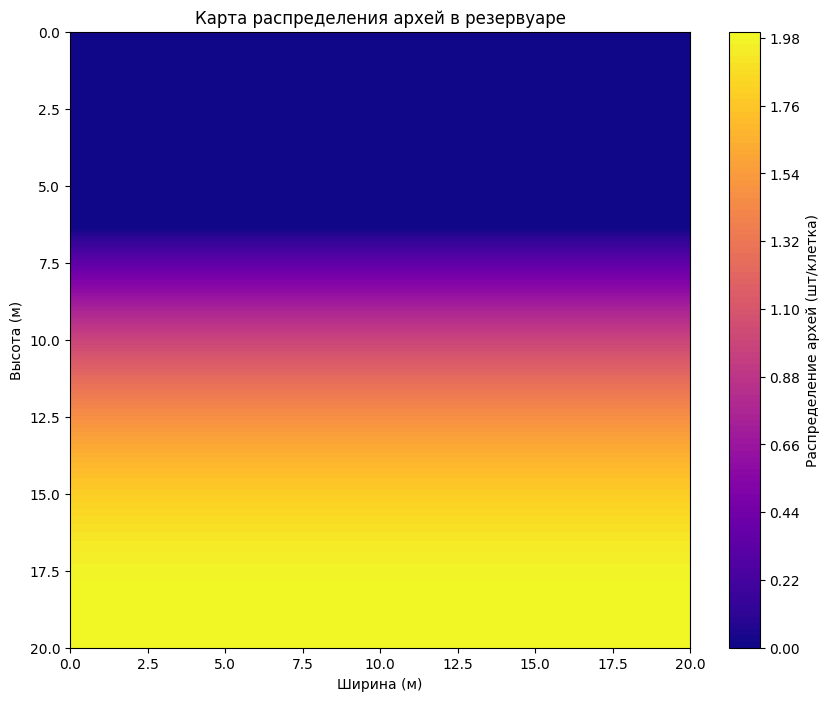

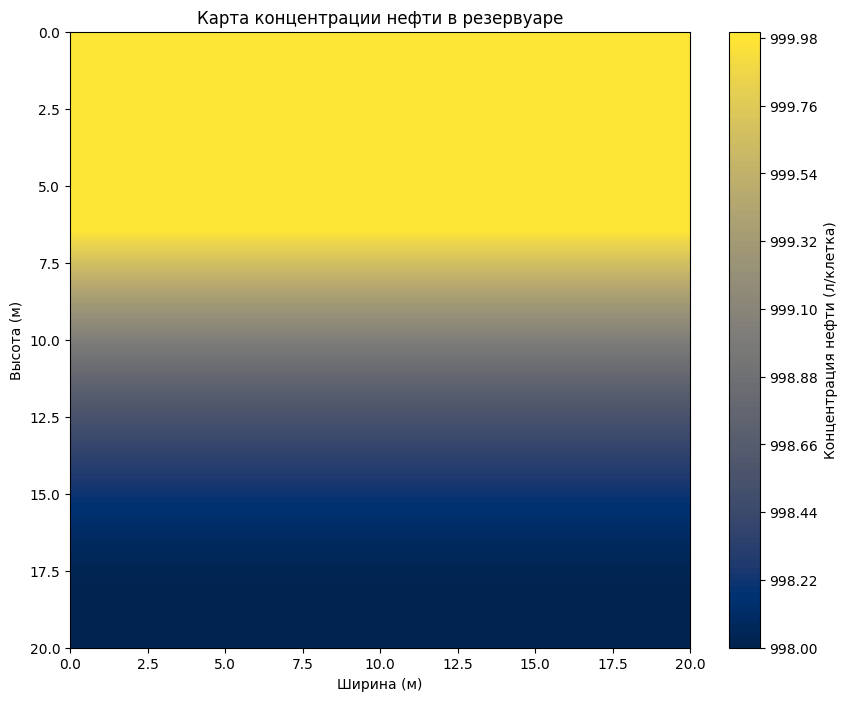

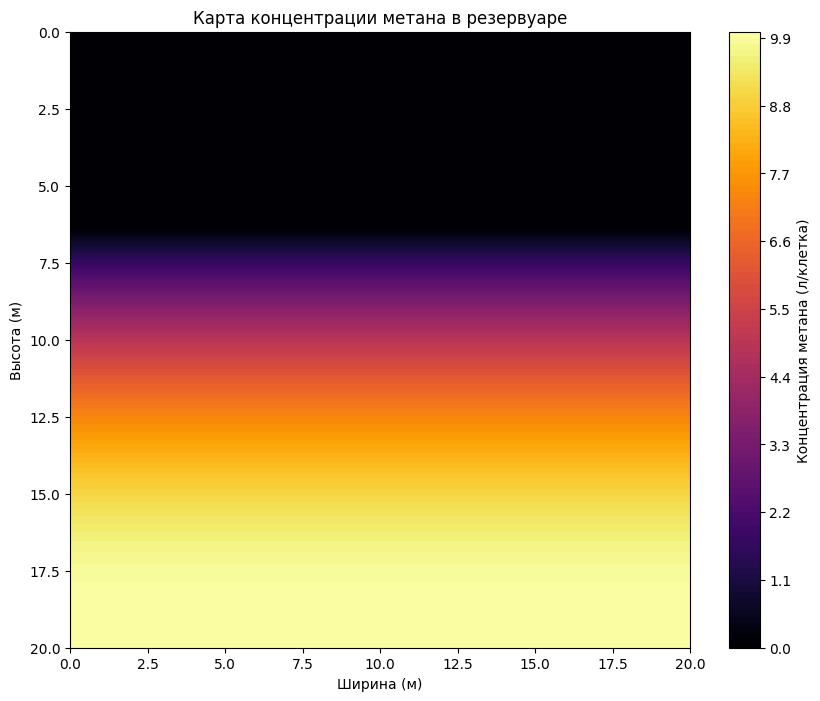

In [1]:
import numpy as np
import matplotlib.pyplot as plt

def create_grid(width, height, num_points=1000):
    X = np.linspace(0, width, num_points)
    Y = np.linspace(0, height, num_points)
    return np.meshgrid(X, Y)

def calculate_pressure(h, p0, rho, g):
    return p0 + rho * g * h

def calculate_archaea_distribution(pressure, ideal_pressure, max_pressure):
    return np.clip(1 - ((pressure - ideal_pressure) / (max_pressure - ideal_pressure))**2, 0, 1)

def update_oil_concentration(initial_oil_concentration, archaea_distribution, consumption_rate):
    oil_concentration = initial_oil_concentration - consumption_rate * archaea_distribution / 100  
    return np.clip(oil_concentration, 0, initial_oil_concentration.max())

def update_methane_concentration(initial_oil_concentration, oil_concentration, methane_production_rate):
    methane_concentration = methane_production_rate * (initial_oil_concentration - oil_concentration) / initial_oil_concentration.max()
    return np.clip(methane_concentration, 0, initial_oil_concentration.max())

def plot_contour(X, Y, data, title, color_map, color_label):
    plt.figure(figsize=(10, 8))
    cp = plt.contourf(X, Y, data, levels=100, cmap=color_map)
    plt.colorbar(cp, label=color_label)
    plt.title(title)
    plt.xlabel('Ширина (м)')
    plt.ylabel('Высота (м)')
    plt.xlim(0, 20)
    plt.ylim(20, 0)
    plt.show()

# Параметры резервуара
params = {
    'width': 20,
    'height': 20,
    'g': 9.81,
    'rho': 800,
    'p0': 1450000,
    'ideal_pressure': 1600000,
    'max_pressure': 1700000,
    'initial_oil_volume': 1000,
    'consumption_rate': 0.1,
    'methane_production_rate': 5
}

# Создание сетки координат (x, y)
X, Y = create_grid(params['width'], params['height'])

# Определение уровней давления по вертикали (h)
h = Y
pressure = calculate_pressure(h, params['p0'], params['rho'], params['g'])

# Расчет распределения архей
archaea_distribution = calculate_archaea_distribution(pressure, params['ideal_pressure'], params['max_pressure']) * 2  

# Изначальная концентрация нефти
initial_oil_concentration = np.ones_like(archaea_distribution) * (params['initial_oil_volume'] / 1000) # перевод в м³

# Обновление концентрации нефти и метана
oil_concentration = update_oil_concentration(initial_oil_concentration, archaea_distribution, params['consumption_rate'])
methane_concentration = update_methane_concentration(initial_oil_concentration, oil_concentration, params['methane_production_rate'])

# Построение графиков
plot_contour(X, Y, pressure / 100000, 'Карта гидростатического давления в резервуаре', 'viridis', 'Гидростатическое давление (Б)')
plot_contour(X, Y, archaea_distribution, 'Карта распределения архей в резервуаре', 'plasma', 'Распределение архей (шт/клетка)')
plot_contour(X, Y, oil_concentration * 1000 , 'Карта концентрации нефти в резервуаре', 'cividis', 'Концентрация нефти (л/клетка)')
plot_contour(X, Y, methane_concentration * 1000 , 'Карта концентрации метана в резервуаре', 'inferno', 'Концентрация метана (л/клетка)')

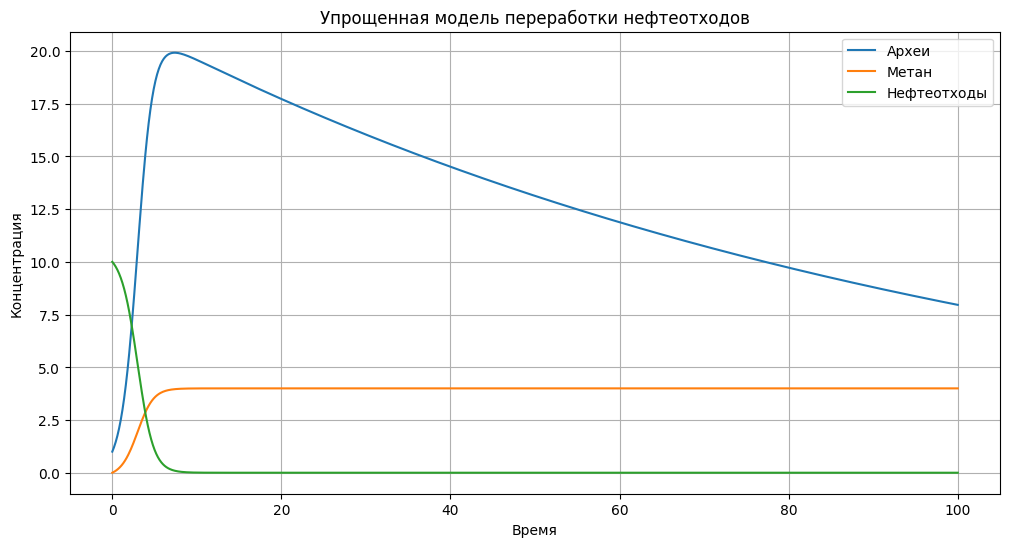

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

def create_grid(width, height, num_points=1000):
    X = np.linspace(0, width, num_points)
    Y = np.linspace(0, height, num_points)
    return np.meshgrid(X, Y)

def calculate_pressure(h, p0, rho, g):
    return p0 + rho * g * h

def calculate_archaea_distribution(pressure, ideal_pressure, max_pressure):
    return np.clip(1 - ((pressure - ideal_pressure) / (max_pressure - ideal_pressure))**2, 0, 1)

def update_archaea_distribution(archaea_distribution, growth_rate, death_rate):
    new_archaea = archaea_distribution * growth_rate
    death = archaea_distribution * death_rate
    archaea_distribution += new_archaea - death
    return np.clip(archaea_distribution, 0, None)

def update_oil_concentration(initial_oil_concentration, archaea_distribution, consumption_rate):
    oil_consumed = consumption_rate * archaea_distribution
    oil_concentration = initial_oil_concentration - oil_consumed
    return np.clip(oil_concentration, 0, initial_oil_concentration.max())

def produce_methane(archaea_distribution, methane_concentration, methane_production_rate, saturation_threshold):
    new_methane = methane_production_rate * archaea_distribution
    new_methane[methane_concentration >= saturation_threshold] = 0
    return new_methane

def update_methane_distribution(methane_concentration, diffusion_coefficient):
    diffusion = diffusion_coefficient * ( 
        np.roll(methane_concentration, 1, axis=0) + np.roll(methane_concentration, -1, axis=0) + 
        np.roll(methane_concentration, 1, axis=1) + np.roll(methane_concentration, -1, axis=1) - 
        4 * methane_concentration 
    )
    methane_concentration += diffusion
    
    methane_shifted = np.roll(methane_concentration, -1, axis=0)
    methane_shifted[-1,:] = 0
    
    methane_shifted += methane_shifted * 0.1
    return np.clip(methane_shifted, 0, None)

def plot_contour(X, Y, data, title, color_map):
    plt.contourf(X, Y, data, levels=100, cmap=color_map)
    plt.colorbar(label='Концентрация')
    plt.title(title)
    plt.xlabel('Ширина (м)')
    plt.ylabel('Высота (м)')
    plt.xlim(0, 20)
    plt.ylim(20, 0)

params = {
    'width': 20,
    'height': 20,
    'g': 9.81,
    'rho': 800,
    'p0': 1450000,
    'ideal_pressure': 1600000,
    'max_pressure': 1700000,
    'initial_oil_volume': 1000,
    'consumption_rate': 0.1,
    'methane_production_rate': 0.1,
    'archaea_growth_rate': 0.01,
    'archaea_death_rate': 0.005,
    'diffusion_coefficient': 0.02,
    'methane_saturation_threshold': 0.1,
}

X, Y = create_grid(params['width'], params['height'])
h = Y
pressure = calculate_pressure(h, params['p0'], params['rho'], params['g'])

initial_oil_concentration = np.ones_like(X) * (params['initial_oil_volume'] / 1000)
archaea_distribution = calculate_archaea_distribution(pressure, params['ideal_pressure'], params['max_pressure']) * 2
methane_concentration = np.zeros_like(X)

fig = plt.figure(figsize=(20, 5))

def update(frame):
    global archaea_distribution
    global methane_concentration
    
    archaea_distribution = update_archaea_distribution(archaea_distribution,
                                                        params['archaea_growth_rate'],
                                                        params['archaea_death_rate'])
    
    oil_concentration = update_oil_concentration(initial_oil_concentration,
                                                  archaea_distribution,
                                                  params['consumption_rate'])
    
    new_methane_production = produce_methane(archaea_distribution,
                                              methane_concentration,
                                              params['methane_production_rate'],
                                              params['methane_saturation_threshold'])
    
    methane_concentration += new_methane_production
    methane_concentration = update_methane_distribution(methane_concentration,
                                                         params['diffusion_coefficient'])
    
    plt.clf()
    
    plt.subplot(1, 3, 1)
    plot_contour(X, Y, archaea_distribution * 10 , 'Распределение архей', 'plasma')  
    
    plt.subplot(1, 3, 2)
    plot_contour(X, Y, oil_concentration * 1000 , 'Концентрация нефти', 'cividis')
    
    plt.subplot(1, 3, 3)
    plot_contour(X, Y, methane_concentration * 1000 , 'Концентрация метана', 'inferno')

ani = animation.FuncAnimation(fig, update, frames=30, interval=200)
ani.save('reservoir_animation.gif', writer='imagemagick')
plt.tight_layout()
plt.show()

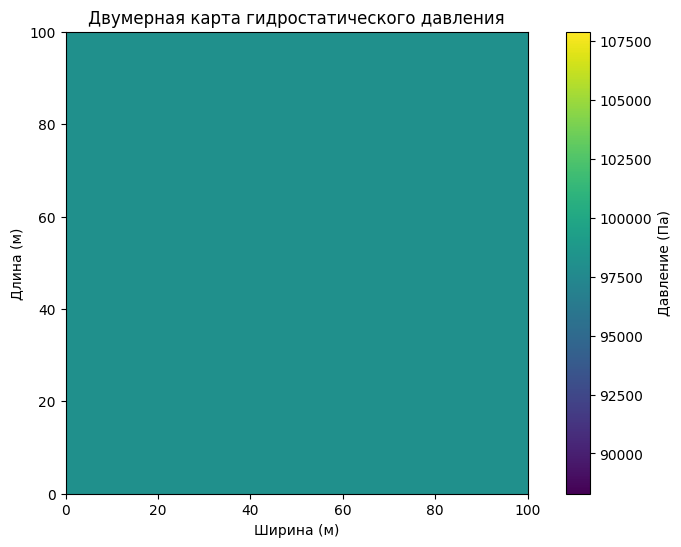

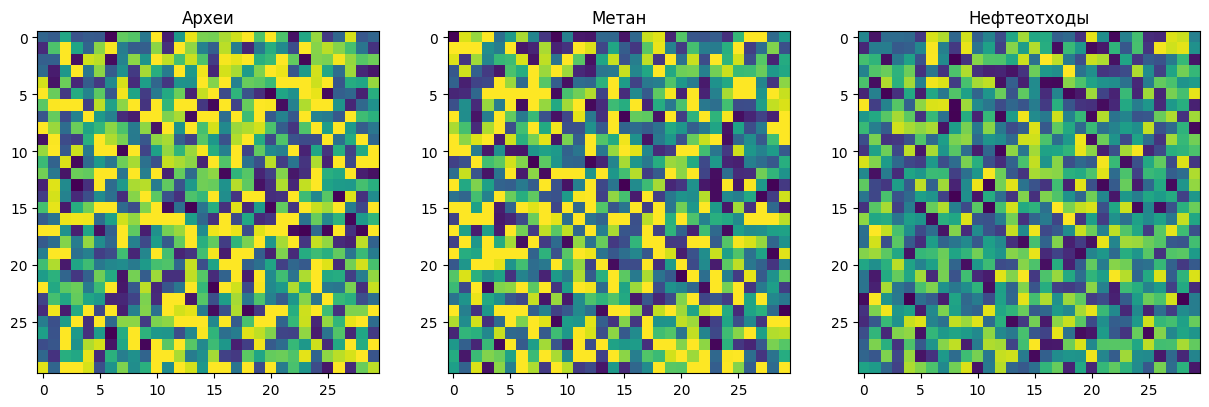

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Параметры (ЗАМЕНИТЕ НА РЕАЛИСТИЧНЫЕ ЗНАЧЕНИЯ ИЗ ЛИТЕРАТУРЫ!)
k_growth = 0.1  # Скорость роста архей (упрощенное значение)
k_death = 0.01  # Скорость гибели архей (упрощенное значение)
k_consumption = 0.05 # Скорость потребления нефтеотходов
k_methane_production = 0.02 # Скорость производства метана

dt = 0.1  # Шаг по времени
t_end = 100  # Конечное время

# Начальные концентрации
C_A = 1.0  # Археи
C_M = 0.0  # Метан
C_O = 10.0 # Нефтеотходы

# Временные ряды
time = np.arange(0, t_end + dt, dt)
C_A_t = np.zeros(len(time))
C_M_t = np.zeros(len(time))
C_O_t = np.zeros(len(time))

C_A_t[0] = C_A
C_M_t[0] = C_M
C_O_t[0] = C_O

# Модель (очень упрощенная!)
for i in range(len(time) - 1):
    dC_A = (k_growth * C_A * C_O - k_death * C_A) * dt
    dC_M = k_methane_production * C_A * C_O * dt
    dC_O = -k_consumption * C_A * C_O * dt

    C_A += dC_A
    C_M += dC_M
    C_O += dC_O

    C_A_t[i+1] = C_A
    C_M_t[i+1] = C_M
    C_O_t[i+1] = C_O

    #Проверка на отрицательные значения
    C_A = max(0, C_A)
    C_M = max(0, C_M)
    C_O = max(0, C_O)

# Построение графиков
plt.figure(figsize=(12, 6))
plt.plot(time, C_A_t, label='Археи')
plt.plot(time, C_M_t, label='Метан')
plt.plot(time, C_O_t, label='Нефтеотходы')
plt.xlabel('Время')
plt.ylabel('Концентрация')
plt.title('Упрощенная модель переработки нефтеотходов')
plt.legend()
plt.grid(True)
plt.show()